# Financial Econometrics 2 - Project 1
## Jan Kubal & Matyáš Mattanelli
### Instructions

**Part A)**

0) We ask you to create a folder for you project, in which you will be working on the project. You will be asked to send us this project that we can look at your progress and browse through your work. Please follow the instructions in the seminar or a documentation of julia about the activation of an environment and use it for your project. (It can be found also here: https://pkgdocs.julialang.org/v1/environments/ even it is from prompt/terminal, in a notebook use `Pkg.activate(".")`) 
* In your project, you will be adding packages, using them, you can create a script files as well and load them (with helper functions if needed.)


1) Use package `MarketData`, `Quandl`, or different one, if needed go to their github pages and `docs`, then **download data for an asset** of your choice.
2) Use plot to look at the data, do some summary statistics, `Statistics`, `DataFrames`, `StatsPlots` packages
3) Use GARCH to **model** asset data and **forecast**.
3) **Plot** forecasts.
    
This part is for you to get you familiar with julia, its syntax, and pacakges.

**Part B)**
- *OLS* vs *ML* estimation HAR
    - Estimate coefficients with different approaches
    - Optim.jl vs Flux.jl
    - Discuss coefficients, show them in scatter, histograms
    - test different activations in NN
    - play around with regularizations
    - Make Q-Q plots, a table of performance

**Part C)**
- Find a dataset or time-series and do the prediction task employing methods (not neccesarily all of them) we covered during lectures L1-L6 (next week)
    - It can be cross-sectional finance example
    - OR forecasting time-series (maybe preferably)
- Use ensemble technique/averaging in final predictions when use neural network models
- Use performance measures
- As an example, and also a wrap-up of NN techniques, you can consult different papers in the literature.
    - Papers on forecasting:
        - Babiak & Barunik (2020) contains NN section and uses Goyal & Welch in forecasting part [arxiv](https://arxiv.org/abs/2009.03394)
        - Feng et al. (2018) Deep Learning for Predicting Asset Returns (https://arxiv.org/pdf/1804.09314.pdf)    
    - Papers on distribution (both predict parameters of distribution):
        - Salinas et al. (2019): DeepAR [pdf](https://arxiv.org/pdf/1704.04110v3.pdf), [python](https://paperswithcode.com/paper/deepar-probabilistic-forecasting-with)
        - Weron et al. (2022): Distributional neural networks for electricity prices forecasting [arxiv pdf](https://arxiv.org/abs/2207.02832)
        - CHALLENGING - to replicate one of the two :) (definitely not necessary)

---

## Environment preparation

In [1]:
#Activate the environment
import Pkg
Pkg.activate(".")
#Pkg.instantiate() #In case the environment is activated for the first time

  Activating project at `d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1`


#### Loading required packages

In [26]:
#Load required packages
import Dates
import MarketData
import Statistics
import Plots
import DataFrames
import StatsPlots
import StatsBase
import ARCHModels
import LinearAlgebra
import Optim
import Random
import Flux

include("utils.jl") #A file containing functions taken from the seminar + custom defined functions

[> Loaded d:\My stuff\School\Master\3. semestr\Financial Econometrics II\Project 1\utils.jl


## Part A)

### 1.

We have chosen the McDonald's stock price as the variable of interest. We will download it from Yahoo Finance. We acquire only 10 years worth of data (January 2012 - December 2021) since ancient history may not have relevance for the present, in fact, it may adversely affect the forecasts.

In [3]:
#Download data for McDonald's stock from Yahoo (42.2s)
t1 = Dates.DateTime(2012, 1, 1) #Starting period
t2 = Dates.DateTime(2022, 1, 1) #Ending period
MCD = MarketData.yahoo("MCD", MarketData.YahooOpt(period1 = t1, period2 = t2));

We are interested only in the adjusted close price so we will store it in a variable. We also calculate the log-returns since we do not expect the price to be stationary.

In [4]:
#Store only the Adjusted Close price
MCD_adj_close = MarketData.values(MCD[:AdjClose])

#Calculate log-returns
MCD_log_ret = diff(log.(MCD_adj_close));

### 2.

In this section we provide some fundamental summary statistics.

In [5]:
#Define function for summary statistics
n(x) = size(x)[1] #Define a function calculating the number of observations
quantile_5(x) = Statistics.quantile(x, 0.05) #Define a function calculating the 5th percentile
quantile_25(x) = Statistics.quantile(x, 0.25) #Define a function calculating the 25th percentile
quantile_75(x) = Statistics.quantile(x, 0.75) #Define a function calculating the 75th percentile
quantile_95(x) = Statistics.quantile(x, 0.95) #Define a function calculating the 95th percentile
sum_stats = [n, Statistics.mean, Statistics.std, quantile_5, quantile_25, Statistics.median, quantile_75, quantile_95, StatsBase.skewness, StatsBase.kurtosis] #Store the functions caclulating summary statistics into a vector for looping
str_info = ["Number of observations: ", "Mean: ", "Standard deviation: ", "5th percentile: ", "25th percentile: ", "Median: ", "75th percentile: ", "95th percentile: ", "Skewness: ", "Kurtosis: "] #Define strings to be printed

#Print summary statistics for raw price
println("Raw price")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_adj_close), digits = 2)))
end

#Print summary statistics for log-returns
println("")
println("Log-returns")
for i in range(1, size(sum_stats)[1])
    println(str_info[i] * string(round(sum_stats[i](MCD_log_ret), digits = 2)))
end


Raw price
Number of observations: 2517.0
Mean: 129.33
Standard deviation: 54.89
5th percentile: 68.85
25th percentile: 77.23
Median: 108.6
75th percentile: 175.74
95th percentile: 228.27
Skewness: 0.54
Kurtosis: -1.03

Log-returns
Number of observations: 2516.0
Mean: 0.0
Standard deviation: 0.01
5th percentile: -0.02
25th percentile: -0.0
Median: 0.0
75th percentile: 0.01
95th percentile: 0.02
Skewness: -0.19
Kurtosis: 37.56


The summary statistics suggest that the price is slightly positively skewed and platykurtic. On the other hand, the returns appear to be more symmetric (even though slightly negatively skewed) and with very heavy tails (high kurtosis). The average return is roughly zero (measured by both the mean and the median) so in general the distribution of the returns does not deviate from our expectations.

We can also plot the time series of the prices as well as returns. We can see that there is an obvious trend in price and as is common for asset prices, the time series is far from stationary. There appears to be a significant drop in price around the year 2020 very likely caused by the coronavirus pandemic.

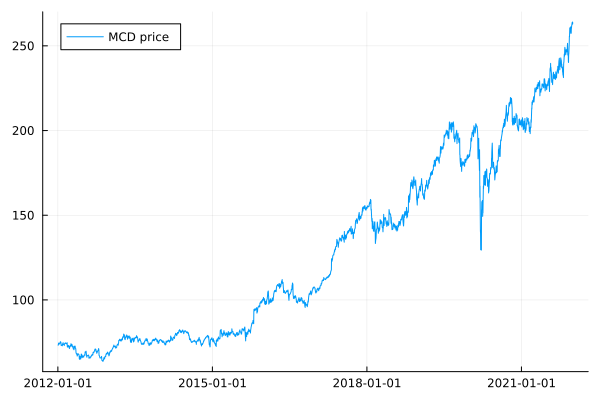

In [6]:
#Plotting the time series of price
Plots.plot(MCD[:AdjClose], labels = "MCD price", legend = :topleft)

On the other hand, the returns appear to be mean-stationary. However, we can observe some large variance clusters. Once again, especially around the time of the Covid-19 outbreak.

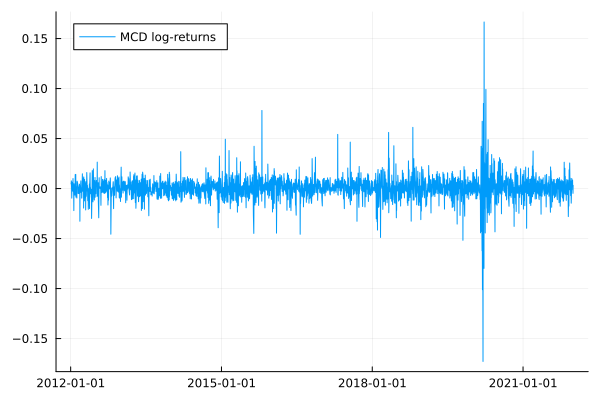

In [7]:
#Plotting the time series of log-returns
Plots.plot(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns", legend = :topleft)

The inspection of histogram may give an insight into the shape of a distribution of a variable. As we can see, the histogram of MCD price below indicates that the series is positively skewed. This corresponds to the positive skewness calculated in the summary statistics.

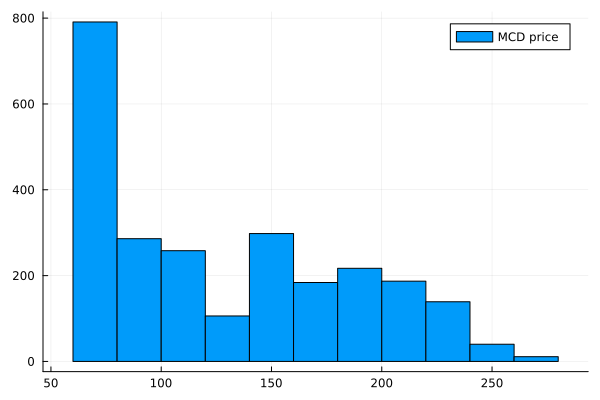

In [8]:
#Plot histogram of price
Plots.histogram(MCD[:AdjClose], labels = "MCD price")

On the other hand, the returns appear to be symmetric and with very heavy tails.

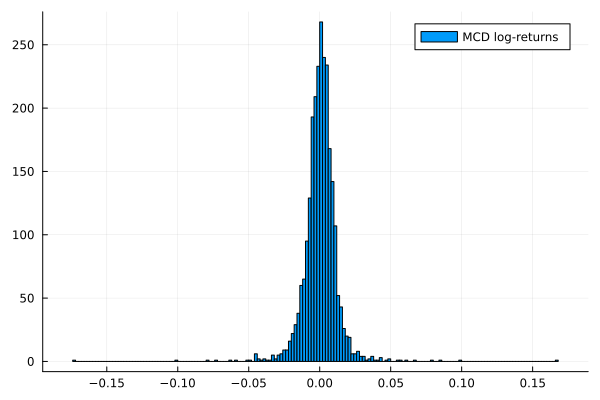

In [9]:
#Plot histogram of log-returns
Plots.histogram(MarketData.TimeArray(MarketData.timestamp(MCD)[2:end], MCD_log_ret), labels = "MCD log-returns")

#### 3. 

In this section we estimate a GARCH model using the returns on the MCD's asset. We use the ``ARCHModels`` package rather than ``GARCH`` due to the incompability of ``GARCH`` with ``Flux`` which is a package used in subsequent parts. Firstly, we will inspect the dependencies in the returns by plotting the Autocorrelation function (ACF).

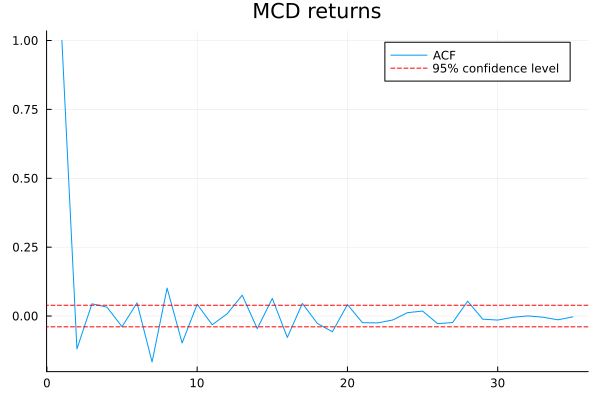

In [7]:
#Plot ACF
plot_ACF(MCD_log_ret, "MCD returns")

As we can see, there appear to be some significant dependencies in the returns. Arguably, these could be modelled using purely GARCH but we will try an ARMA model first and see the results. We will start with a simple AR(1) model.

In [11]:
#Fit AR(1)
ar1 = ARCHModels.fit(ARCHModels.AR{1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000567895  0.000249483   2.27629    0.0228
φ₁  -0.11939      0.0537782    -2.22005    0.0264
─────────────────────────────────────────────────

Volatility parameters:
────────────────────────────────────────────
     Estimate   Std.Error  z value  Pr(>|z|)
────────────────────────────────────────────
ω  0.00014689  1.75786e-5  8.35618    <1e-16
────────────────────────────────────────────


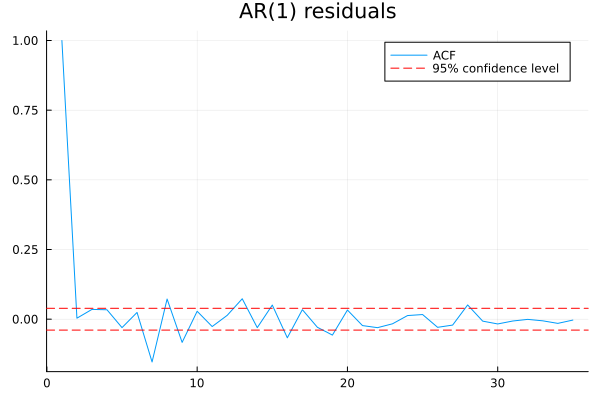

In [12]:
#Plot ACF of AR(1) residuals
plot_ACF(ARCHModels.residuals(ar1), "AR(1) residuals")

As can be seen, the coefficient of the first lag is significant and we have successfully modeled some dependencies. Nevertheless, there are still some significant dependecies left in the AR(1) residuals. Therefore, we will try estimating an ARMA(1,1) model.

In [13]:
#Fit ARMA(1,1)
arma11 = ARCHModels.fit(ARCHModels.ARMA{1,1}, MCD_log_ret)


TGARCH{0, 0, 0} model with Gaussian errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate   Std.Error    z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000636255  0.00028516   2.23122     0.0257
φ₁  -0.253834     0.261442    -0.970903    0.3316
θ₁   0.135425     0.254011     0.533147    0.5939
─────────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────────
      Estimate   Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────────
ω  0.000146814  1.74947e-5   8.3919    <1e-16
─────────────────────────────────────────────


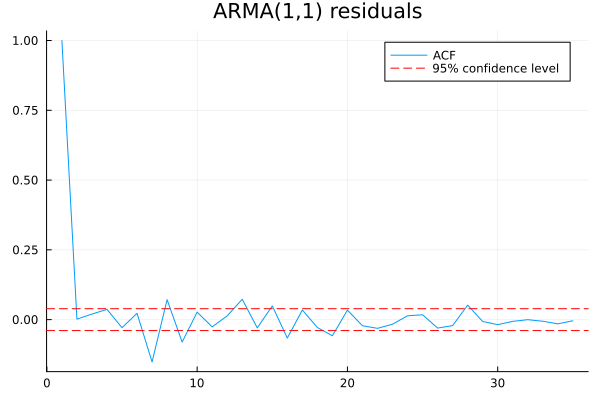

In [14]:
#Plot ACF of ARMA(1,1) residuals
plot_ACF(ARCHModels.residuals(arma11), "ARMA(1,1) residuals")

Since both the coefficients on AR(1) and MA(1) are insignificant and the improvement upon the AR(1) model is negligible, we will opt for the AR(1) model to avoid overfitting. We will hope to model the remaining dependencies using volatility modelling. Prior to estimating GARCH, we will verify the presence of ARCH effects using the LM test.

In [15]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(ARCHModels.residuals(ar1), 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          658.201

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   658.201


The LM test confirms the presence of ARCH effects in the AR(1) residuals. Therefore, we will estimate a GARCH model in the next step. As is common, we choose the GARCH(1,1) specification since it is very often sufficient to model the volatility. In addition, given the shape of the histogram of the returns, we assume a *t*-distribution to accomodate the heavy tails.

In [16]:
#Estimating GARCH
spec = ARCHModels.GARCH{1, 1}([0, .1, .08]) #Define the specifications and choose intial values for the coefficients
MCD_garch = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
ARCHModels.fit!(MCD_garch) #Fitting the model


GARCH{1, 1} model with Student's t errors, T=2516.

Mean equation parameters:
─────────────────────────────────────────────────
        Estimate    Std.Error   z value  Pr(>|z|)
─────────────────────────────────────────────────
c    0.000870848  0.000167954   5.18505    <1e-06
φ₁  -0.0470442    0.0198131    -2.3744     0.0176
─────────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   6.39587e-6  2.97084e-6   2.15289    0.0313
β₁  0.854375    0.0516742   16.5339     <1e-60
α₁  0.0908537   0.030525     2.97637    0.0029
──────────────────────────────────────────────

Distribution parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ν   4.21025   0.363053  11.5968    <1e-30
─────────────────────────────────────────


As can be seen, all the estimated coefficients are statistically significant. We can asses whether we successfully modelled the dependencies by inspecting the ACF plot.

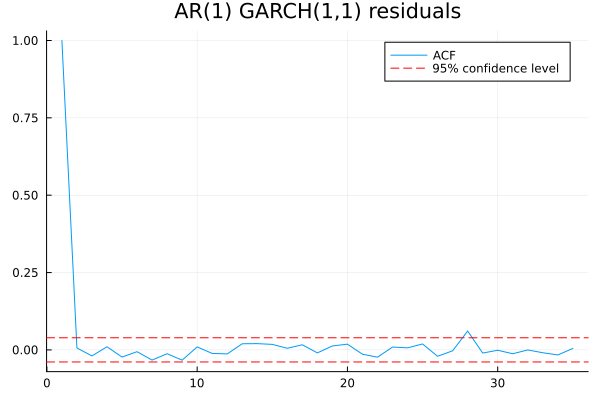

In [17]:
#Plot ACF for AR(1) GARCH(1,1) residuals
plot_ACF(ARCHModels.residuals(MCD_garch), "AR(1) GARCH(1,1) residuals")

The ACF plot suggests that the model residuals from virtually no dependencies. We can further verify this by performing the ARCH test.

In [18]:
#Test for ARCH effects
ARCHModels.ARCHLMTest(MCD_garch, 7)

ARCH LM test for conditional heteroskedasticity
-----------------------------------------------
Population details:
    parameter of interest:   T⋅R² in auxiliary regression
    value under h_0:         0
    point estimate:          0.966186

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9954

Details:
    sample size:                    2516
    number of lags:                 7
    LM statistic:                   0.966186


The p-value of the LM test is very high suggesting that there are no significant ARCH effects in the model residuals.

#### 4.

Now that we seem to have a reliable model, we can make forecasts and plot them. We will start with the fitted volatility values.

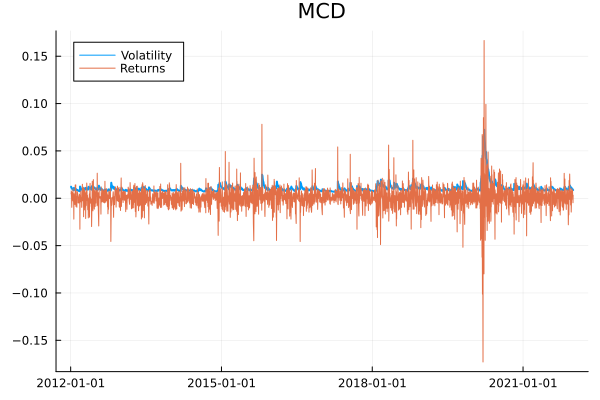

In [19]:
#Plot the fitted values
MCD_garch_vol = MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), ARCHModels.volatilities(MCD_garch))
Plots.plot(MCD_garch_vol, title = "MCD", legend = :topleft, label = "Volatility", lw = 2)
Plots.plot!(MarketData.TimeArray(MarketData.timestamp(MCD[2:end]), MCD_log_ret), label = "Returns")


As can be seen, the model seems to at least partially capture some of the volatility clusters. In the next step we will perform out of sample forecasts using a rolling window.

In [20]:
#Making 1-step-ahead predictions on a rolling window
window_size = 500 #Specify the size of the rolling window
MCD_garch_vol_oot = Vector{Float64}(undef, length(MCD_log_ret) - window_size) #Initialize an empty vector for the forecasts
for i in 1:length(MCD_garch_vol_oot) #Loop through the rolling windows
    MCD_garch_rol = ARCHModels.UnivariateARCHModel(spec, MCD_log_ret[i:(window_size + i - 1)]; dist = ARCHModels.StdT(3.), meanspec = ARCHModels.AR{1}([0,-.1])) #Specify the model
    ARCHModels.fit!(MCD_garch) #Fit the model
    MCD_garch_vol_oot[i] = ARCHModels.predict(MCD_garch_rol)
end

Now we will compare the forecasted volatility with the fitted volatility.

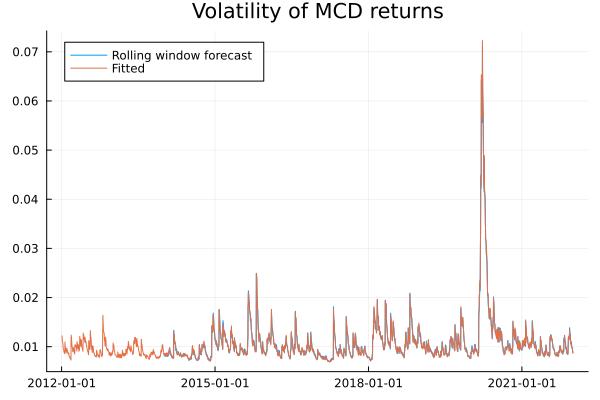

In [21]:
#Plot the predicted volatility vs. the fitted volatility
MCD_garch_vol_oot_timearray = MarketData.TimeArray(MarketData.timestamp(MCD_garch_vol[(window_size + 1):end]), MCD_garch_vol_oot) #Create a TimeArray from the volatility forecasts
Plots.plot(MCD_garch_vol_oot_timearray, title = "Volatility of MCD returns", label = "Rolling window forecast", legend = :topleft)
Plots.plot!(MCD_garch_vol, label = "Fitted")

As can be seen, there are some differences but the values are very similar. We can inspect the deviations further by plotting the difference of the two series.

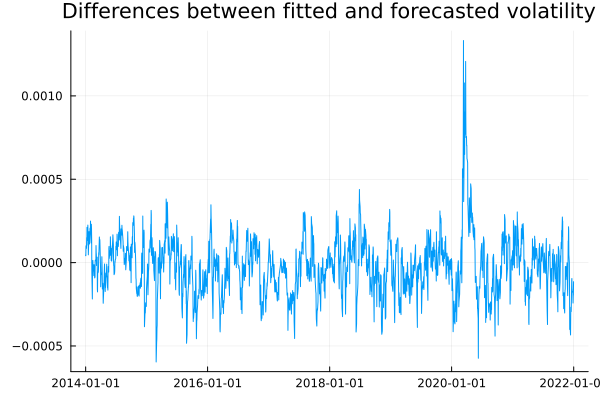

In [22]:
#Plot differences between fitted and forecasted volatility
Plots.plot(MCD_garch_vol[(window_size + 1):end] .- MCD_garch_vol_oot_timearray, title = "Differences between fitted and forecasted volatility", legend = false)

Even though the differences are very small, it appears that the fitted volatility is generally larger. We can also see that the greatest differences are in the first quarter of 2020 which may be associated with the coronavirus outbreak.

---

## Part B)

In this part we estimate the HAR model on our data using various methods and then compare the results. We start by computing Realized Variance: $RV_t = r^2_t$

In [8]:
#Calcualate RV 
target = MCD_log_ret.^2;

Next, we calculate the predictors for the HAR-RV model:

* Daily: $RV_{d_t} = RV_t$
* Weekly: $RV_{w_t} = \frac{1}{5}\sum_{i=0}^4RV_{t-i}$
* Monthly: $RV_{m_t} = \frac{1}{22}\sum_{i=0}^{22}RV_{t-i}$

As a target shall be used $RV_{t+1}$. Data are then split to train and test set. The former will be used for model development and the latter for evaluation. In addition, we standardize both sets using the mean and standard deviation of the training part to aid optimization.

*Note: `HAR_regressors()` taken from Seminar 3*

In [9]:
#Compute HAR regressors
predictors = HAR_regressors(target)

#Shift the target
target = target[23:end];

In [11]:
#Split into training and testing
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size)

#Standardization
mean_X_train = mapslices(StatsBase.mean, X_train; dims = 2) #Save the mean
std_X_train = mapslices(StatsBase.std, X_train; dims = 2) #Save the standard deviation
X_train = standardize(X_train) #Standardize the training set (using a custom define function from utils)
X_test = standardize(X_test); #Standardize the testing set (using mean and std of the training set)

Firstly, we will estimate the HAR coefficients using OLS. We define a loss function and find its minimum using gradient descent.

In [16]:
#OLS via Optim
OLS_optim = Optim.optimize(loss_HAR, [1., 1., 1., 1.], Optim.GradientDescent()) #Optimize the loss
OLS_optim.minimizer

4-element Vector{Float64}:
 9.582971883177813e-5
 5.74837556499221e-6
 1.4315222484371664e-5
 1.0534413408377777e-5

We can compare the results of optimization with the analytical solution. As can be seen, the coefficients are virtually identical.

In [17]:
#Analytical OLS solution
X_train_with_int = [ones((1, size(X_train)[2])); X_train] #Add ones for intercept estimation
inv(X_train_with_int * transpose(X_train_with_int)) * X_train_with_int * transpose(y_train) #Calculate the coefficients

4×1 Matrix{Float64}:
 9.58297188307503e-5
 5.74553199047348e-6
 1.4322570548935856e-5
 1.0530839069278419e-5

Now that we have the coefficients, we can calculate the Mean Squared Error on the training and test sets.

In [18]:
#Calculating Mean Squared Error
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))

OLS train MSE: 7.649668599909526e-8
OLS test MSE: 3.7976373385708473e-6


As expected, the MSE is higher for the test set. As required, we also provide a QQ-plot of the residuals.

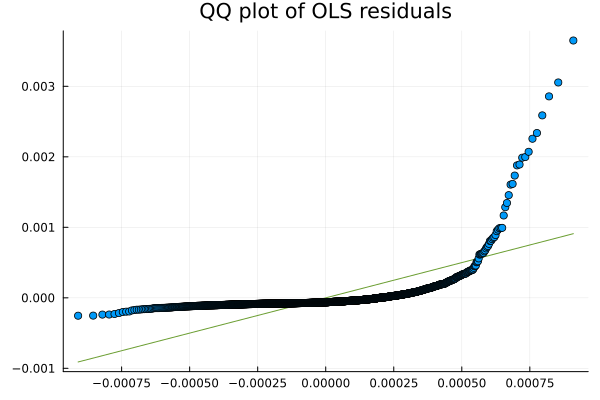

In [17]:
#QQ plot of OLS residuals
OLS_resid = transpose(y_train)[:,1] - calc_fitted(OLS_optim.minimizer, X_train)
StatsPlots.qqnorm(OLS_resid, title = "QQ plot of OLS residuals")

As the QQ plot shows, the distribution of the residuals from the HAR regression is very far from normal.

 Next, we will estimate a neural network with no hidden layer and the inputs being the HAR regressors. This should be equivalent to estimating a linear regression.

In [19]:
#NN estimation
Random.seed!(420) #Set the seed for reproducibility
model = Flux.Dense(3 => 1) #Define the specification
loss_HAR_NN(x, y) = Flux.Losses.mse(model(x), y) #Define the loss function
opt = Flux.Descent() #Specify the optimizer as gradient Descent
parameters = Flux.params(model) #Save the parameters to be estimated
data_train = [(X_train, y_train)] #Specify the training data
for epoch in 1:300 #Train the model iteratively
    Flux.train!(loss_HAR_NN, parameters, data_train, opt) #Train
    epoch % 20 == 0 ? println("Epoch $epoch \t MSE (train): ", loss_HAR_NN(X_train, y_train), " \t MSE (test): ", loss_HAR_NN(X_test, y_test)) : nothing #Report the losses for each 20 epochs
end

Epoch 20 	 MSE (train): 0.0044648973 	 MSE (test): 0.20967084
Epoch 40 	 MSE (train): 0.00013439417 	 MSE (test): 0.008631899
Epoch 60 	 MSE (train): 4.87411e-6 	 MSE (test): 0.0003402144
Epoch 80 	 MSE (train): 2.490996e-7 	 MSE (test): 1.6803555e-5
Epoch 100 	 MSE (train): 8.2708105e-8 	 MSE (test): 4.4042417e-6
Epoch 120 	 MSE (train): 7.672022e-8 	 MSE (test): 3.8454996e-6
Epoch 140 	 MSE (train): 7.6504726e-8 	 MSE (test): 3.8042742e-6
Epoch 160 	 MSE (train): 7.6496974e-8 	 MSE (test): 3.798786e-6
Epoch 180 	 MSE (train): 7.64967e-8 	 MSE (test): 3.7978295e-6
Epoch 200 	 MSE (train): 7.649669e-8 	 MSE (test): 3.7976508e-6
Epoch 220 	 MSE (train): 7.64967e-8 	 MSE (test): 3.7976172e-6
Epoch 240 	 MSE (train): 7.649669e-8 	 MSE (test): 3.797611e-6
Epoch 260 	 MSE (train): 7.649668e-8 	 MSE (test): 3.7976095e-6
Epoch 280 	 MSE (train): 7.649668e-8 	 MSE (test): 3.7976092e-6
Epoch 300 	 MSE (train): 7.649668e-8 	 MSE (test): 3.7976095e-6


As can be seen, not only the MSE decreases with each 20 epochs but for the last 40 epochs it no longer further decreases which suggests that the optimization converged. We can now compare the MSEs with the values obtained via OLS.

In [20]:
#Compare the losses of OLS and ML
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))

OLS train MSE: 7.649668599909526e-8
OLS test MSE: 3.7976373385708473e-6
ML train MSE: 7.649668e-8
ML test MSE: 3.7976095e-6


The values are virtually the same. The same should apply to the estimated coefficients:

In [21]:
#Compare coefficients of OLS and ML
[OLS_optim.minimizer [model.bias; model.weight[1,:]]]

4×2 Matrix{Float64}:
 9.58297e-5  9.58297e-5
 5.74838e-6  5.74554e-6
 1.43152e-5  1.43226e-5
 1.05344e-5  1.05308e-5

In the next step we will attempt to train a more sophisticated neural network to see if we can achieve a lower loss. For this purpose we have defined a generic function with a large number of parameters. We allow the presence of only a single hidden layer since it should be sufficient for approximation of any function. We will start by training a simple neural network with 3 hidden nodes and a ReLU activation function. We will use Gradient Descent for optimization.

In [23]:
#Train a neural network with 3 hidden nodes
NN_3_inits, NN_3 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 10000, learn_rate = 0.1);

Epoch 1000 	 MSE (train): 5.3189165e-6 	 MSE (test): 0.000103026585
Epoch 2000 	 MSE (train): 1.198331e-6 	 MSE (test): 4.468243e-5
Epoch 3000 	 MSE (train): 5.482375e-7 	 MSE (test): 3.450764e-5
Epoch 4000 	 MSE (train): 3.2374064e-7 	 MSE (test): 3.140224e-5
Epoch 5000 	 MSE (train): 2.2148177e-7 	 MSE (test): 3.037572e-5
Early stopping at epoch 5120 	 MSE (train): 2.1310284e-7 	 MSE (test): 3.032054e-5


After trying different learning rates and increasing the number of epochs, the testing loss does not appear to decrease any further. We can compare the losses with the previous models.

In [24]:
#Compare losses
println("OLS train MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_train), transpose(y_train))))
println("OLS test MSE: " * string(MSE(calc_fitted(OLS_optim.minimizer, X_test), transpose(y_test))))
println("ML train MSE: " * string(loss_HAR_NN(X_train, y_train)))
println("ML test MSE: " * string(loss_HAR_NN(X_test, y_test)))
println("NN (3 nodes) train MSE: " * string(Flux.Losses.mse(NN_3(X_train), y_train)))
println("NN (3 nodes) test MSE: " * string(Flux.Losses.mse(NN_3(X_test), y_test)))

OLS train MSE: 7.649668599909526e-8
OLS test MSE: 3.7976373385708473e-6
ML train MSE: 7.649668e-8
ML test MSE: 3.7976095e-6
NN (3 nodes) train MSE: 2.1310284e-7
NN (3 nodes) test MSE: 3.032054e-5


As we can see, the simpler models appear to outperform the more complex neural network. This may be a sign of overfitting. Before trying different parameter settings, we will compare the initial coefficients of the neural networks with their optimized counterparts.

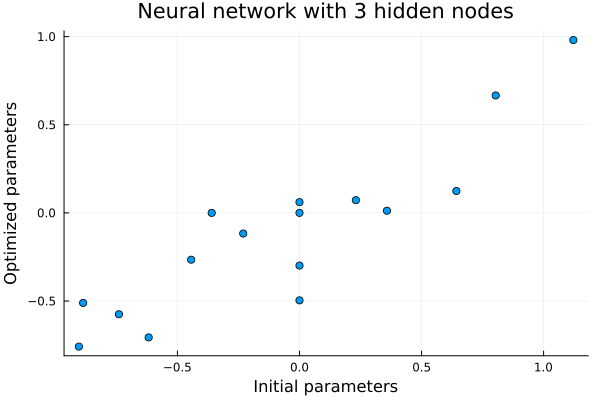

In [25]:
#Plot scatter of coefficients
Plots.scatter(NN_3_inits, extract_params(NN_3), legend = false, title = "Neural network with 3 hidden nodes", xlab = "Initial parameters", ylab = "Optimized parameters")

The scatter plot indicates that there is a clear linear relationship between the initial and optimized coefficients. This suggests that the initial values were not unreasonable. We will provide a histogram of the coefficients as well.

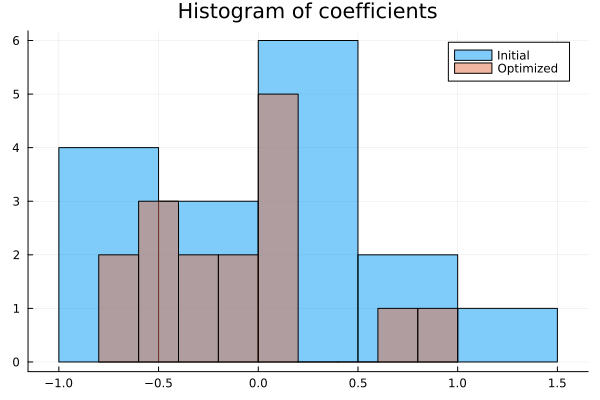

In [28]:
#Histogram of coefficients
Plots.histogram(NN_3_inits, title = "Histogram of coefficients", label = "Initial", bins = 8, fillalpha = 0.5)
Plots.histogram!(extract_params(NN_3), label = "Optimized", bins = 8, fillalpha = 0.5)

Similarly to to the scatter plot, the histograms shows that the distribution of the coefficients appear to be very similar. Nevertheless, we have estimated only 16 coefficients which seems to be an insufficient amount of observations to estimate the shape of a distribution. 

As we could see in the previous estimation, we did not manage to improve the loss of the OLS model. We will now attempt to surpass the perfomance by searching over a parameter grid. We have defined a devoted function which will estimate a neural network for each combination of the specified parameter grid. Apart from increasing the number of nodes, we also introduce two types of regularization (L2 and dropout). This might help to prevent overfitting. In addition, we try different learning rates, optimizers, and activation functions.

In [ ]:
#Perform grid search (5m 29.7s)
param_grid = Dict(:nodes => [3, 7, 10], :learn_rate => [0.001, 0.01, 0.1], :α => [0, 0.1, 1], :dropout => [0, 0.2, 0.5], :opt => [Flux.Descent, Flux.Adam], :activ_func => [Flux.relu, Flux.tanh, Flux.sigmoid]) #Specify the parameter grid
gridsearch_res = gridSearch(param_grid, X_train, y_train, X_test, y_test; verbose = false);

Below we show the best 10 models according to MSE. As we can see, all of these models were able to achieve lower MSE than OLS. This demonstrates the importance of hyperparameter boosting. The best model uses 7 nodes, both types of regularization, and the sigmoid activation function.

In [28]:
#Show best 10 models
DataFrames.sort(gridsearch_res, :MSE)[begin:10,:]

Row,α,opt,nodes,learn_rate,dropout,activ_func,MSE
,Float64,DataType,Int64,Float64,Float64,Function,Float64
1,0.1,Descent,7,0.01,0.5,σ,3.19701e-6
2,0.0,Descent,7,0.1,0.2,σ,3.23097e-6
3,0.1,Descent,7,0.1,0.2,σ,3.47914e-6
4,0.0,Descent,7,0.01,0.5,σ,3.49305e-6
5,0.1,Descent,7,0.1,0.5,σ,3.57701e-6
6,0.0,Descent,7,0.1,0.5,σ,3.57806e-6
7,1.0,Descent,7,0.01,0.5,σ,3.59614e-6
8,1.0,Descent,7,0.01,0.2,σ,3.63291e-6
9,0.1,Descent,7,0.1,0.0,σ,3.64431e-6


We can take a look at the QQ plot of the residuals of the best model.

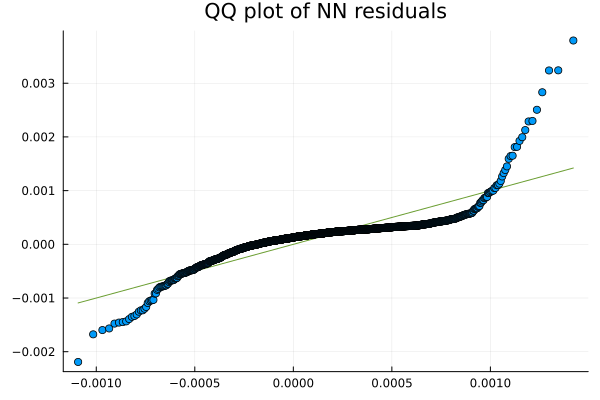

In [36]:
#QQ plot of residuals of the best model
best_model = train_NN(X_train, y_train, X_test, y_test; α = 0.1, opt = Flux.Descent, nodes = 7, learn_rate = 0.01, dropout = 0.5, activ_func = Flux.sigmoid, return_inits = false, verbose = false) #Reestimate the model with best parameters
best_model_resid = y_train - best_model(X_train) #Calculate residuals
StatsPlots.qqnorm(best_model_resid[1,:], title = "QQ plot of NN residuals")

The plot looks slightly better than for OLS but the distribution of the residuals is still far from normal.

---

# Part C)

In [47]:
#Define function performing ensemble averaging for a set of NN models
function get_ensemble(X_train, y_train, X_test, y_test, models; weights = false, loss = Flux.Losses.mse)
   #parameters: X_train, y_train, X_test, y_test: data used for training the NNs
   #            models: list containing trained NNs (product of train_NN() function)
   #optional:   weights: list of integers or floats of same length as models
   #            loss: loss function to be used for evaluating result
   fitted_ensemble = Matrix{Float64}(undef, 1, length(y_train)) #initialize empty matrices for ensembled values
   preds_ensemble = Matrix{Float64}(undef, 1, length(y_test))

   if weights == false #get weights of each model to be averaged
      weights = ones(length(models)) ./length(models) #if no weights given, produce simple average (same weights for all)
   else  
      weights = weights ./sum(weights) #(transform vector of weights such that it sums to 1)
   end

   i = 1
   for NN in models #for each model, get fitted/predicted values, multiply by weight and add them to the ensemble
      fitted_ensemble = fitted_ensemble .+ (NN(X_train)) .*weights[i]
      preds_ensemble = preds_ensemble .+ (NN(X_test)) .*weights[i]
      i +=1
   end      

   println("Score of the ensemble:")
   println("MSE (train): ", loss(fitted_ensemble, y_train), " \t MSE (test): ", loss(preds_ensemble, y_test))
   return [fitted_ensemble, preds_ensemble]
end;

In [80]:
NN_3_L2_ensemble_1 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, α = 0.1, return_inits = false);
NN_3_L2_ensemble_3 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, α = 0.1, return_inits = false);
NN_3_L2_ensemble_2 = train_NN(X_train, y_train, X_test, y_test; nodes = 3, n_epochs = 1000, learn_rate = 0.1, α = 0.1, return_inits = false);

Epoch 100 	 MSE (train): 7.923077e-6 	 MSE (test): 0.0009238744
Epoch 200 	 MSE (train): 7.869453e-8 	 MSE (test): 4.645669e-6


Epoch 300 	 MSE (train): 7.7171904e-8 	 MSE (test): 4.141232e-6
Epoch 400 	 MSE (train): 7.71869e-8 	 MSE (test): 4.1371272e-6
Converged at epoch 405 	 MSE (train): 7.718695e-8 	 MSE (test): 4.137114e-6


Epoch 100 	 MSE (train): 4.3116524e-6 	 MSE (test): 8.169935e-5


Epoch 200 	 MSE (train): 7.9660715e-8 	 MSE (test): 4.200073e-6
Epoch 300 	 MSE (train): 7.7209165e-8 	 MSE (test): 4.137754e-6


Epoch 400 	 MSE (train): 7.718756e-8 	 MSE (test): 4.137067e-6
Converged at epoch 404 	 MSE (train): 7.718751e-8 	 MSE (test): 4.1370654e-6
Epoch 100 	 MSE (train): 1.4064972e-6 	 MSE (test): 0.00019879003


Epoch 200 	 MSE (train): 7.777627e-8 	 MSE (test): 4.4637386e-6
Epoch 300 	 MSE (train): 7.719058e-8 	 MSE (test): 4.141841e-6


Converged at epoch 373 	 MSE (train): 7.718736e-8 	 MSE (test): 4.137305e-6


In [84]:
get_ensemble(X_train, y_train, X_test, y_test, [NN_3_L2_ensemble_1, NN_3_L2_ensemble_1, NN_3_L2_ensemble_1], weights = [1,1,1]);

Score of the ensemble:
MSE (train): 7.718694793834634e-8 	 MSE (test): 3.917533779643212e-6


In the example above, the ensamble of three L2 regularized networks achieves a better test set MSE (3.92e-6), then each network individually (4.1371e-6, 4.1370e-6, 4.1373e-6).

Next, a Cross-Validation is implemented for the RNN models.

In [154]:
##helper function to get sample size and return indicies ranges to be used further in CV
function get_timesplits(sample_size; splits=4, test_size = 0.8) #parameters: Int, Int, float
    foldsize = floor(Int, (sample_size/splits)) #compute size of one fold
    fold_test_size = floor(Int, (foldsize*test_size)) #compute size of testing set in each fold
    ranges = [(foldsize*i-foldsize+1):(foldsize*i) for i in 1:splits] #get ranges of folds (e.g. 1:100)
    timesplits = [[range[1]:range[1]+fold_test_size, range[1]+fold_test_size+1:range[end]] for range in ranges] #get ranges of train/test splits (e.g. [1:81, 82:100])
    return timesplits
end

get_timesplits (generic function with 6 methods)

In [176]:
##Function performing the Cross-Validation of specified RNN
function cross_validate(X_train, y_train; folds = 4, test_size = 0.8, loss = Flux.Losses.mse, get_models = false,
                        dropout = false, nodes = 5, activ_func = Flux.relu, output_func = Flux.identity, 
                        loss_func = Flux.Losses.mse, α = 0, return_inits = false, learn_rate = 0.001, 
                        opt = Flux.Descent(learn_rate), batch_size = false, n_epochs = 200)
    #X and y need to be specified (assumed X_train, y_train) from before; 
    #other params: n. of folds, test size to be used in CV,loss function to be used, and all params of train_NN()
    timesplits = get_timesplits(size(X_train, 2), folds, test_size)

    mses_ls = []
    models = []
    for k in 1:folds
        #split the data on training and testing , target on training and testing
        train_range = timesplits[k][1] #get the range of X for current fold
        test_range = timesplits[k][2] #get the range of y for current fold

        X_fold_train = X_train[:,train_range] #get current fold training X and y training
        y_fold_train = y_train[:, train_range]

        X_fold_test = X_train[:,test_range] #get current fold training X and y training
        y_fold_test = y_train[:, test_range]        

        #train the network
        NN_fold = train_NN(X_fold_train, y_fold_train, X_fold_test, y_fold_test; 
                                            dropout = dropout, nodes = nodes, n_epochs = n_epochs, 
                                            learn_rate = learn_rate, activ_func = activ_func, 
                                            return_inits = return_inits, output_func = output_func, 
                                            loss_func = loss_func, α = α, opt = opt, batch_size = batch_size);
        append!(models, NN_fold)
        
        #get the mse
        mse = loss(NN_fold(X_fold_test), y_fold_test)
        append!( mses_ls, mse ) #append MSE
        println("Fold $k/$folds, Out-of-sample MSE: ", mse)
    end
    #avergae the mses
    println("Cross-validation done. Average MSE: ", StatsBase.mean(mses_ls))

    if get_models
        return mses_ls, models
    else
        return mses_ls
    end
end

cross_validate (generic function with 1 method)

In [186]:
cross_validate(X_train, y_train);

Epoch 20 	 MSE (train): 0.03980757 	 MSE (test): 0.080136016
Epoch 40 	 MSE (train): 0.03683553 	 MSE (test): 0.07477592


Epoch 60 	 MSE (train): 0.03418196 	 MSE (test): 0.069904305
Epoch 80 	 MSE (train): 0.03181491 	 MSE (test): 0.065470144
Epoch 100 	 MSE (train): 0.029698698 	 MSE (test): 0.0614282
Epoch 120 	 MSE (train): 0.027804496 	 MSE (test): 0.057739872
Epoch 140 	 MSE (train): 0.02610754 	 MSE (test): 0.05436991
Epoch 160 	 MSE (train): 0.024585918 	 MSE (test): 0.051287025
Epoch 180 	 MSE (train): 0.023220232 	 MSE (test): 0.048463218
Epoch 200 	 MSE (train): 0.021993339 	 MSE (test): 0.045873594
Fold 1/4, Out-of-sample MSE: 0.045873594
Epoch 20 	 MSE (train): 0.15687525 	 MSE (test): 1.7993122
Epoch 40 	 MSE (train): 0.14657971 	 MSE (test): 1.7370188
Epoch 60 	 MSE (train): 0.1374971 	 MSE (test): 1.6789384
Epoch 80 	 MSE (train): 0.12945005

 	 MSE (test): 1.6246517
Epoch 100 	 MSE (train): 0.12228943 	 MSE (test): 1.5737947
Epoch 120 	 MSE (train): 0.11588906 	 MSE (test): 1.5260531
Epoch 140 	 MSE (train): 0.1101406 	 MSE (test): 1.4811442
Epoch 160 	 MSE (train): 0.10495264 	 MSE (test): 1.4387964
Epoch 180 	 MSE (train): 0.100251324 	 MSE (test): 1.3988062
Epoch 200 	 MSE (train): 0.09597155 	 MSE (test): 1.3609749
Fold 2/4, Out-of-sample MSE: 1.3609749
Epoch 20 	 MSE (train): 0.20101672 	 MSE (test): 0.07457422
Epoch 40 	 MSE (train): 0.18184066 	 MSE (test): 0.065947294


Epoch 60 	 MSE (train): 0.165337 	 MSE (test): 0.058746874
Epoch 80 	 MSE (train): 0.15105732 	 MSE (test): 0.05270669
Epoch 100 	 MSE (train): 0.1386342 	 MSE (test): 0.04761239
Epoch 120 	 MSE (train): 0.12776856 	 MSE (test): 0.04329193
Epoch 140 	 MSE (train): 0.11821586 	 MSE (test): 0.039606865
Epoch 160 	 MSE (train): 0.10977212 	 MSE (test): 0.03644481
Epoch 180 	 MSE (train): 0.1022736 	 MSE (test): 0.033715334
Epoch 200 	 MSE (train): 0.09558209 	 MSE (test): 0.031344485
Fold 3/4, Out-of-sample MSE: 0.031344485
Epoch 20 	 MSE (train): 1.2977339 	 MSE (test): 1.0310187
Epoch 40 	 MSE (train): 0.8260592 	 MSE (test): 0.6644843
Epoch 60 	 MSE (train): 0.54333204 	 MSE (test): 0.4439717
Epoch 80 	 MSE (train): 0.36740392 	 MSE (test): 0.30618978
Epoch 100 	 MSE (train): 0.25518283 	 MSE (test): 0.21776178
Epoch 120 	 MSE (train): 0.18221623 	 MSE (test): 0.15982276


Epoch 140 	 MSE (train): 0.1338175 	 MSE (test): 0.121161304
Epoch 160 	 MSE (train): 0.10134162 	 MSE (test): 0.095018014
Epoch 180 	 MSE (train): 0.079333805 	 MSE (test): 0.07711008
Epoch 200 	 MSE (train): 0.064264104 	 MSE (test): 0.06466984
Fold 4/4, Out-of-sample MSE: 0.06466984
Cross-validation done. Average MSE: 0.37571573
